## Estimate Intrinsic Dimension of Wikipedia Embeddings

In [ ]:
# Get Cohere Wikipedia embeddings from Hugging Face

from huggingface_hub import login
from datasets import load_dataset

import time

# Login to Hugging Face
login(token="YourOwnHuggingFaceToken")

print("Loading the complete Cohere Wikipedia embeddings dataset...")
start_time = time.time()

# Load the entire dataset (non-streaming mode)
# This will load everything into memory at once
docs = load_dataset("Cohere/wikipedia-22-12-en-embeddings", split="train")

loading_time = time.time() - start_time
print(f"Dataset loaded in {loading_time:.2f} seconds")
# print(f"Dataset size: {len(docs['train'])} examples")

In [ ]:
# Convert embedding vectors from dataset to numpy array

import numpy as np
import os

# Get the total number of rows
num_rows = len(docs)
print(f"Total number of rows: {num_rows}")

# Define chunk size for processing and saving
# Each embedding is 768 * 4 bytes (float32) ≈ 3 KB
# Processing 1M embeddings at a time ≈ 3 GB of memory
chunk_size = 1000000
num_chunks = (num_rows + chunk_size - 1) // chunk_size

output_dir = "D:/WikipediaEmbeddings_Cohere/wikipedia_embeddings_chunks"
os.makedirs(output_dir, exist_ok=True)

print("Processing and saving embeddings in chunks...")
extract_start = time.time()

for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, num_rows)
    current_size = end_idx - start_idx
    
    print(f"Processing chunk {chunk_idx+1}/{num_chunks} (rows {start_idx} to {end_idx-1})...")
    
    # Process this chunk in smaller batches
    batch_size = 10000
    num_batches = (current_size + batch_size - 1) // batch_size
    
    # Initialize array just for this chunk
    chunk_embeddings = np.zeros((current_size, 768), dtype=np.float32)
    
    for batch_idx in range(num_batches):
        batch_start = start_idx + batch_idx * batch_size
        batch_end = min(start_idx + (batch_idx + 1) * batch_size, end_idx)
        
        # FIXED: Properly access Hugging Face dataset
        # Get batch of examples using the proper slicing for datasets.arrow_dataset.Dataset
        batch = docs.select(range(batch_start, batch_end))
        
        # FIXED: Extract embeddings using the proper method for accessing features
        # Assuming 'emb' is a feature in your dataset
        batch_embeddings = np.array(batch['emb'], dtype=np.float32)
        
        # Store in the chunk array
        local_start = batch_start - start_idx
        local_end = batch_end - start_idx
        chunk_embeddings[local_start:local_end] = batch_embeddings
        
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == num_batches:
            print(f"  Processed batch {batch_idx+1}/{num_batches}")
    
    # Save this chunk to disk
    chunk_filename = os.path.join(output_dir, f"embeddings_chunk_{chunk_idx:03d}.npy")
    np.save(chunk_filename, chunk_embeddings)
    print(f"Saved chunk {chunk_idx+1} to {chunk_filename}")
    
    # Free memory
    del chunk_embeddings
    
print(f"All processing completed in {time.time() - extract_start:.2f} seconds")

# Create a metadata file with information about the chunks
with open(os.path.join(output_dir, "metadata.txt"), "w") as f:
    f.write(f"Total embeddings: {num_rows}\n")
    f.write(f"Embedding dimensions: 768\n")
    f.write(f"Number of chunks: {num_chunks}\n")
    f.write(f"Chunk size: {chunk_size}\n")
    f.write("Data type: float32\n")
    f.write("File format: NumPy .npy\n")

# OPTIONAL: To recover disk space on SSD C:, manually delete downloaded dataset here after execution of this cell: C:\Users\{username}\.cache\huggingface\datasets\

In [ ]:
# Bring embeddings into SSD C: from slower USB drive D:

import shutil

# This won't fail if destination exists (Python 3.8+)
shutil.copytree("D:/WikipediaEmbeddings_Cohere/wikipedia_embeddings_chunks", "C:/Users/rozmu/Documents/JupyterLabStuff/IntrinsicDimWikipedia/wikipedia_embeddings_chunks", dirs_exist_ok=True)

In [1]:
# Get randomly sampled X% of embedding vectors

import numpy as np
import os
import random
from pathlib import Path

X = 0.06

def reservoir_sample_vectors(directory, sample_percentage, seed=None):
    """
    Memory-efficient reservoir sampling of vectors from .npy files.
    This approach maintains constant memory usage regardless of total data size.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    npy_files = list(Path(directory).glob("*.npy"))
    if not npy_files:
        raise ValueError(f"No .npy files found in {directory}")
    
    # First pass: count total vectors
    total_vectors = 0
    for file_path in npy_files:
        arr = np.load(file_path, mmap_mode='r')
        total_vectors += arr.shape[0]
    
    sample_count = int(total_vectors * sample_percentage / 100)
    print(f"Reservoir sampling {sample_count:,} vectors from {total_vectors:,} total")
    
    # Initialize reservoir
    reservoir = None
    vectors_seen = 0
    
    for file_path in npy_files:
        arr = np.load(file_path, mmap_mode='r')
        
        for i in range(arr.shape[0]):
            vectors_seen += 1
            
            if reservoir is None:
                # Initialize reservoir with first vectors
                reservoir = np.zeros((sample_count, 768), dtype=arr.dtype)
            
            if len(reservoir) < sample_count:
                # Fill reservoir
                reservoir[len(reservoir)] = arr[i]
            else:
                # Replace with probability sample_count/vectors_seen
                j = random.randint(0, vectors_seen - 1)
                if j < sample_count:
                    reservoir[j] = arr[i]
        
        print(f"Processed {file_path.name}: {vectors_seen:,} vectors seen")
    
    return reservoir[:min(sample_count, vectors_seen)]

sampled_data = reservoir_sample_vectors("wikipedia_embeddings_chunks", X, seed=54)

Reservoir sampling 21,100 vectors from 35,167,920 total
Processed embeddings_chunk_000.npy: 1,000,000 vectors seen
Processed embeddings_chunk_001.npy: 2,000,000 vectors seen
Processed embeddings_chunk_002.npy: 3,000,000 vectors seen
Processed embeddings_chunk_003.npy: 4,000,000 vectors seen
Processed embeddings_chunk_004.npy: 5,000,000 vectors seen
Processed embeddings_chunk_005.npy: 6,000,000 vectors seen
Processed embeddings_chunk_006.npy: 7,000,000 vectors seen
Processed embeddings_chunk_007.npy: 8,000,000 vectors seen
Processed embeddings_chunk_008.npy: 9,000,000 vectors seen
Processed embeddings_chunk_009.npy: 10,000,000 vectors seen
Processed embeddings_chunk_010.npy: 11,000,000 vectors seen
Processed embeddings_chunk_011.npy: 12,000,000 vectors seen
Processed embeddings_chunk_012.npy: 13,000,000 vectors seen
Processed embeddings_chunk_013.npy: 14,000,000 vectors seen
Processed embeddings_chunk_014.npy: 15,000,000 vectors seen
Processed embeddings_chunk_015.npy: 16,000,000 vector

0.01 0.02 16.646375300198383
0.019999999999999997 0.03 15.695883263393304
0.03 0.04 15.06794095329881
0.04 0.05 14.593476101422517
0.049999999999999996 0.06 14.188132735399964
0.060000000000000005 0.07 13.814499485109224
0.07 0.08 13.528779822166662
0.08000000000000002 0.09000000000000001 13.244047327747275
0.09000000000000001 0.1 13.006077396481508
0.1 0.11 12.762763174316827
0.11000000000000001 0.12000000000000001 12.5571665158205
0.12000000000000001 0.13 12.372326028329462
0.12999999999999998 0.13999999999999999 12.177921000800252
0.13999999999999999 0.15 12.0120547462314
0.15 0.16 11.805961701254017
0.15999999999999998 0.16999999999999998 11.664245573639647
0.16999999999999998 0.18 11.485598867130383
0.18 0.19 11.340488135785616
0.18999999999999997 0.19999999999999998 11.19606124301008
0.19999999999999998 0.21 11.054976303081068
0.21 0.22 10.909046576052862
0.21999999999999997 0.22999999999999998 10.785580813121037
0.22999999999999998 0.24 10.643729543122422
0.24 0.25 10.5334505718

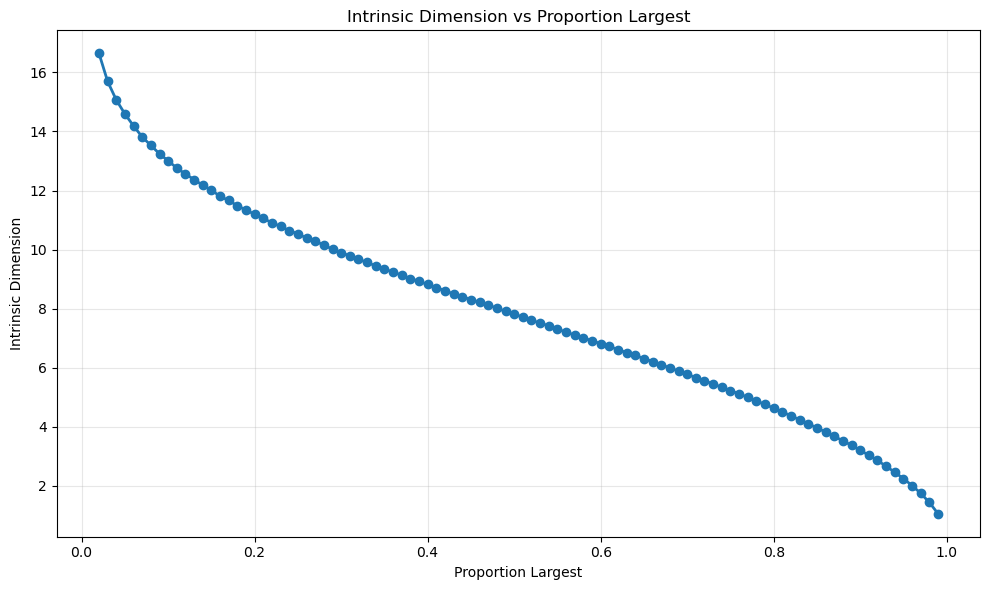

In [2]:
# Estimate intrinsic dimension of sampled vectors by correlation dimension method.
import skdim
import os
import matplotlib.pyplot as plt
import numpy as np

os.environ['LOKY_MAX_CPU_COUNT'] = '1'

Sample_Count = sampled_data.shape[0]

# Lists to store data for plotting
proportion_largest_values = []
intrinsic_dim_values = []

for i in range(98):
    proportion_largest = .02 + (i*.01)
    proportion_smallest = proportion_largest - .01
    ID_Estimator = skdim.id.CorrInt(int(proportion_smallest*Sample_Count),int(proportion_largest*Sample_Count))
    IntrinsicDim = ID_Estimator.fit_transform(sampled_data)
    print(proportion_smallest, proportion_largest, IntrinsicDim)
    
    # Store values for plotting
    proportion_largest_values.append(proportion_largest)
    intrinsic_dim_values.append(IntrinsicDim)

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(proportion_largest_values, intrinsic_dim_values, marker='o', linewidth=2, markersize=6)
plt.xlabel('Proportion Largest')
plt.ylabel('Intrinsic Dimension')
plt.title('Intrinsic Dimension vs Proportion Largest')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[-95.04920368 -78.92171734 -55.1203581  -43.99041089 -38.94883082
 -32.96764566 -28.52260787 -26.13512128 -24.06420767 -22.44554403
 -19.5218573  -18.96227575 -18.0135641  -18.59796498 -17.39045863
 -16.01814171 -16.18787189 -14.47688121 -14.27559164 -14.35073335
 -13.4697745  -13.26585165 -12.60651206 -12.57826553 -11.85129208
 -12.30803054 -13.83169532 -12.24497206 -11.59512686 -11.47461899
 -11.05119824 -11.17341264 -11.05296153 -10.77524168 -10.38392438
 -10.57993537 -10.53213351 -10.02263094 -10.74505676 -10.50549186
 -10.73925143 -10.05159969  -9.48309126  -9.64186684  -9.48678938
  -9.81052389 -10.49253865 -10.27227857  -9.77443332 -10.45536669
  -9.96208652  -9.33540118 -10.14741773 -10.78522234 -10.1047651
  -9.81086725  -9.65372121  -9.65571795  -9.6286228   -9.96108395
 -10.53134499  -9.78681948 -10.10857984 -10.49398902 -10.7205475
 -10.52065655 -10.64573962 -10.97441269 -10.80870573 -10.98995246
 -10.86602561 -11.10277033 -11.09092076 -11.18913754 -11.382851
 -12.04517217 

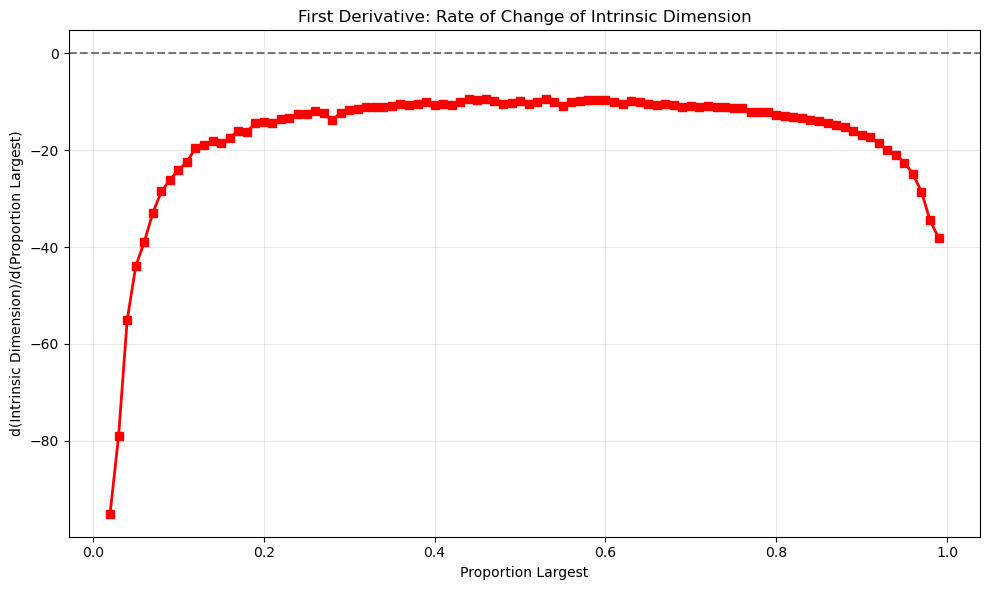

Mean derivative: -16.5866
Standard deviation: 12.9846
Min derivative: -95.0492 at proportion = 0.020
Max derivative: -9.3354 at proportion = 0.530


In [3]:
# Calculate the first derivative of Intrinsic Dimension with respect to Proportion Largest
import numpy as np
import matplotlib.pyplot as plt

# Calculate the first derivative using numpy's gradient function
# This computes the derivative using central differences where possible
derivative_values = np.gradient(intrinsic_dim_values, proportion_largest_values)
print(derivative_values)

# Alternative: Manual calculation using forward differences
# derivative_manual = []
# for i in range(len(intrinsic_dim_values) - 1):
#     dy = intrinsic_dim_values[i+1] - intrinsic_dim_values[i]
#     dx = proportion_largest_values[i+1] - proportion_largest_values[i]
#     derivative_manual.append(dy / dx)

# Create the derivative plot
plt.figure(figsize=(10, 6))
plt.plot(proportion_largest_values, derivative_values, marker='s', linewidth=2, markersize=6, color='red')
plt.xlabel('Proportion Largest')
plt.ylabel('d(Intrinsic Dimension)/d(Proportion Largest)')
plt.title('First Derivative: Rate of Change of Intrinsic Dimension')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # Add horizontal line at y=0
plt.tight_layout()
plt.show()

# Print some statistics about the derivative
print(f"Mean derivative: {np.mean(derivative_values):.4f}")
print(f"Standard deviation: {np.std(derivative_values):.4f}")
print(f"Min derivative: {np.min(derivative_values):.4f} at proportion = {proportion_largest_values[np.argmin(derivative_values)]:.3f}")
print(f"Max derivative: {np.max(derivative_values):.4f} at proportion = {proportion_largest_values[np.argmax(derivative_values)]:.3f}")

0.001 0.002 20.18789297129802
0.002 0.003 19.41632001747125
0.003 0.004 18.868354331909952
0.004 0.005 18.50208059396432
0.005 0.006 18.191143077600323
0.006 0.007 17.92028888593334
0.007 0.008 17.6958003858162
0.008 0.009000000000000001 17.501716893437738
0.009000000000000001 0.01 17.310318830404942
0.010000000000000002 0.011000000000000001 17.144498457110757
0.011 0.012 16.98894030410762
0.012 0.013 16.89716446208086
0.013000000000000001 0.014 16.729757419130436
0.014000000000000002 0.015000000000000001 16.615382781026057
0.015 0.016 16.511398233743606
0.016 0.017 16.330047639478238
0.017 0.018000000000000002 16.31280430689881
0.018000000000000002 0.019000000000000003 16.187503838447782
0.019000000000000003 0.020000000000000004 16.124385264420457
0.019999999999999997 0.020999999999999998 16.012114178826003


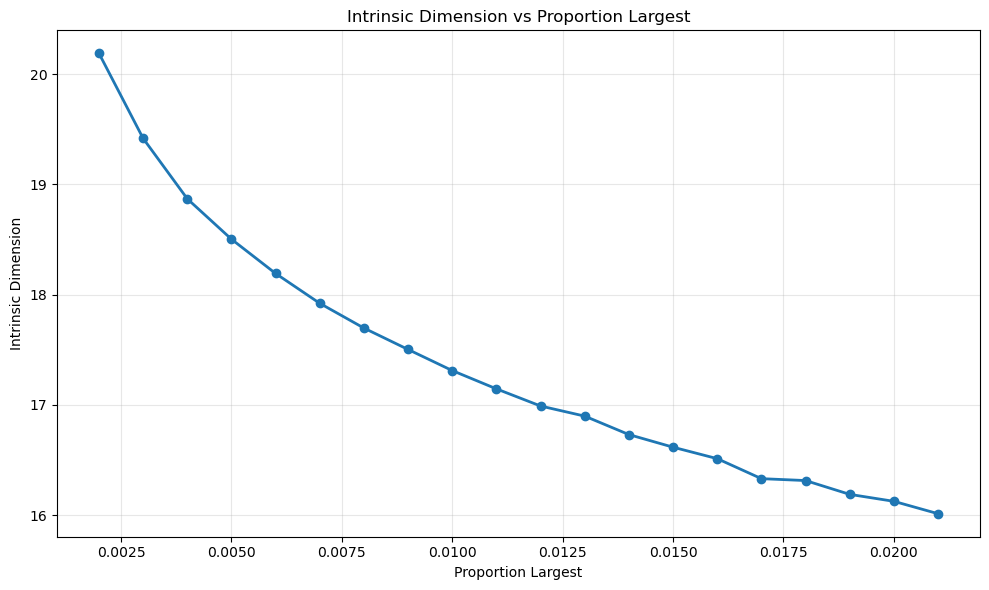

In [2]:
# Estimate intrinsic dimension of sampled vectors by correlation dimension method.
import skdim
import os
import matplotlib.pyplot as plt
import numpy as np

os.environ['LOKY_MAX_CPU_COUNT'] = '1'

Sample_Count = sampled_data.shape[0]

# Lists to store data for plotting
proportion_largest_values = []
intrinsic_dim_values = []

for i in range(20):
    proportion_largest = .002 + (i*.001)
    proportion_smallest = proportion_largest - .001
    ID_Estimator = skdim.id.CorrInt(int(proportion_smallest*Sample_Count),int(proportion_largest*Sample_Count))
    IntrinsicDim = ID_Estimator.fit_transform(sampled_data)
    print(proportion_smallest, proportion_largest, IntrinsicDim)
    
    # Store values for plotting
    proportion_largest_values.append(proportion_largest)
    intrinsic_dim_values.append(IntrinsicDim)

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(proportion_largest_values, intrinsic_dim_values, marker='o', linewidth=2, markersize=6)
plt.xlabel('Proportion Largest')
plt.ylabel('Intrinsic Dimension')
plt.title('Intrinsic Dimension vs Proportion Largest')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[-771.57295383 -659.76931969 -457.11971175 -338.60562715 -290.89585402
 -247.67134589 -209.28599625 -192.74077771 -178.60921816 -160.68926315
 -123.66699751 -129.59144249 -140.89084053 -109.17959269 -142.66757077
  -99.29696342  -71.27190052  -94.20952124  -87.69482981 -112.27108559]


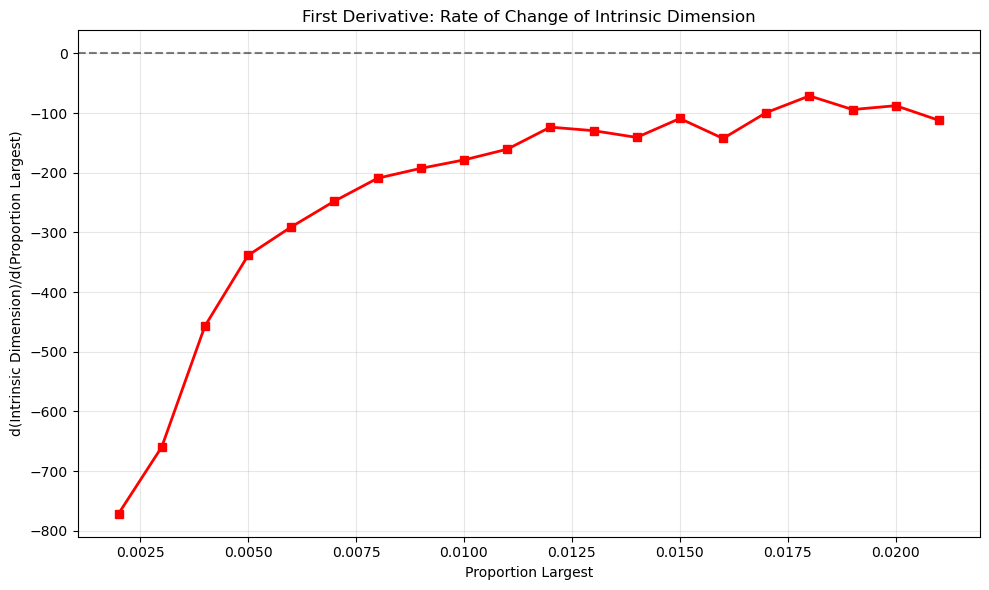

Mean derivative: -230.8850
Standard deviation: 187.2205
Min derivative: -771.5730 at proportion = 0.002
Max derivative: -71.2719 at proportion = 0.018


In [3]:
# Calculate the first derivative of Intrinsic Dimension with respect to Proportion Largest
import numpy as np
import matplotlib.pyplot as plt

# Calculate the first derivative using numpy's gradient function
# This computes the derivative using central differences where possible
derivative_values = np.gradient(intrinsic_dim_values, proportion_largest_values)
print(derivative_values)

# Alternative: Manual calculation using forward differences
# derivative_manual = []
# for i in range(len(intrinsic_dim_values) - 1):
#     dy = intrinsic_dim_values[i+1] - intrinsic_dim_values[i]
#     dx = proportion_largest_values[i+1] - proportion_largest_values[i]
#     derivative_manual.append(dy / dx)

# Create the derivative plot
plt.figure(figsize=(10, 6))
plt.plot(proportion_largest_values, derivative_values, marker='s', linewidth=2, markersize=6, color='red')
plt.xlabel('Proportion Largest')
plt.ylabel('d(Intrinsic Dimension)/d(Proportion Largest)')
plt.title('First Derivative: Rate of Change of Intrinsic Dimension')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # Add horizontal line at y=0
plt.tight_layout()
plt.show()

# Print some statistics about the derivative
print(f"Mean derivative: {np.mean(derivative_values):.4f}")
print(f"Standard deviation: {np.std(derivative_values):.4f}")
print(f"Min derivative: {np.min(derivative_values):.4f} at proportion = {proportion_largest_values[np.argmin(derivative_values)]:.3f}")
print(f"Max derivative: {np.max(derivative_values):.4f} at proportion = {proportion_largest_values[np.argmax(derivative_values)]:.3f}")